In [ ]:
!pip install nilearn

     |████████████████████████████████| 9.6 MB 4.5 MB/s 
     |████████████████████████████████| 38.1 MB 3.2 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
from nilearn import datasets, plotting, decomposition, regions, connectome, plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
patient_df = pd.read_csv("/content/drive/MyDrive/Alzheimer's Detection/patient_ids.csv")
ids = list(patient_df['ID'])

In [ ]:
data_dir = "/content/drive/MyDrive/Alzheimer's Detection/data/"

In [ ]:
data = datasets.fetch_oasis_vbm(data_dir=data_dir)

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/struct.py:774: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


In [ ]:
age = data.ext_vars['age']
# age, educ, socio-economic status, mini-mental state examination, Clinical Dementia Rating, estimated Total Intracranial Volume, brain volumes, Atlas Scale Facto
white_matter_maps = []
gray_matter_maps = []
labels = []
for i in ids:
    for j in range(len(data.ext_vars)):
        if (str(data.ext_vars[j][0]).split('_')[1] == i.split('_')[1]):
            white_matter_maps.append(data.white_matter_maps[j])
            gray_matter_maps.append(data.gray_matter_maps[j])
            labels.append(data.ext_vars[j][7])


In [ ]:
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm', data_dir=data_dir)
atlas_filename = atlas.maps
atlas_labels = atlas.labels

In [ ]:
from nilearn.input_data import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, memory='nilearn_cache', verbose=5)

white_matter_masked = masker.fit_transform(white_matter_maps)
gray_matter_masked = masker.fit_transform(gray_matter_maps)

/usr/local/lib/python3.7/dist-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract([ "/content/drive/MyDrive/Alzheimer's "
  'Detection/data/oasis1/OAS1_0028_MR1/mwrc2OAS1_0028_MR1_mpr_anon_fslswapdim_bet.nii.gz',
  "/content/drive/MyDrive/Alzheimer's "
  'Detection/data/oasis1/OAS1_0031_MR1/mwrc2OAS1_0031_MR1_mpr_anon_fslswapdim_bet.nii.gz',
  "/content/drive/MyDrive/Alzheimer's "
  'Detection/data/oasis1/OAS1_0035_MR1/mwrc2OAS1_0035_MR1_mpr_anon_fslswapdim_bet.nii.gz',
  "/content/drive/MyDrive/Alzheimer's "
  'Detection/data/oasis1/OAS1_0052_MR1/mwrc2OAS1_0052_MR1_mpr_anon_fslswapdim_bet.nii.gz',
  "/content/drive/MyDrive/Alzheimer's "
  'De

In [ ]:
# Check if white matter data matches expectation
alz_wmm = white_matter_masked[0:25]
td_wmm = white_matter_masked[26:]


avg_alz_wmm = np.mean(alz_wmm, axis=0)
avg_td_wmm = np.mean(td_wmm, axis=0)

diff_mat = abs(avg_alz_wmm) - abs(avg_td_wmm)

# Similar data for gray matter maps that was unused but could be interetsing

alz_gmm = gray_matter_masked[np.array(labels) == 1]
td_gmm = gray_matter_masked[np.array(labels) == 0]

avg_alz_gmm = np.mean(alz_gmm, axis=0)
avg_td_gmm = np.mean(td_gmm, axis=0)

diff_mat_g = abs(avg_alz_gmm) - abs(avg_td_gmm)


26


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47],
 <a list of 48 Text major ticklabel objects>)

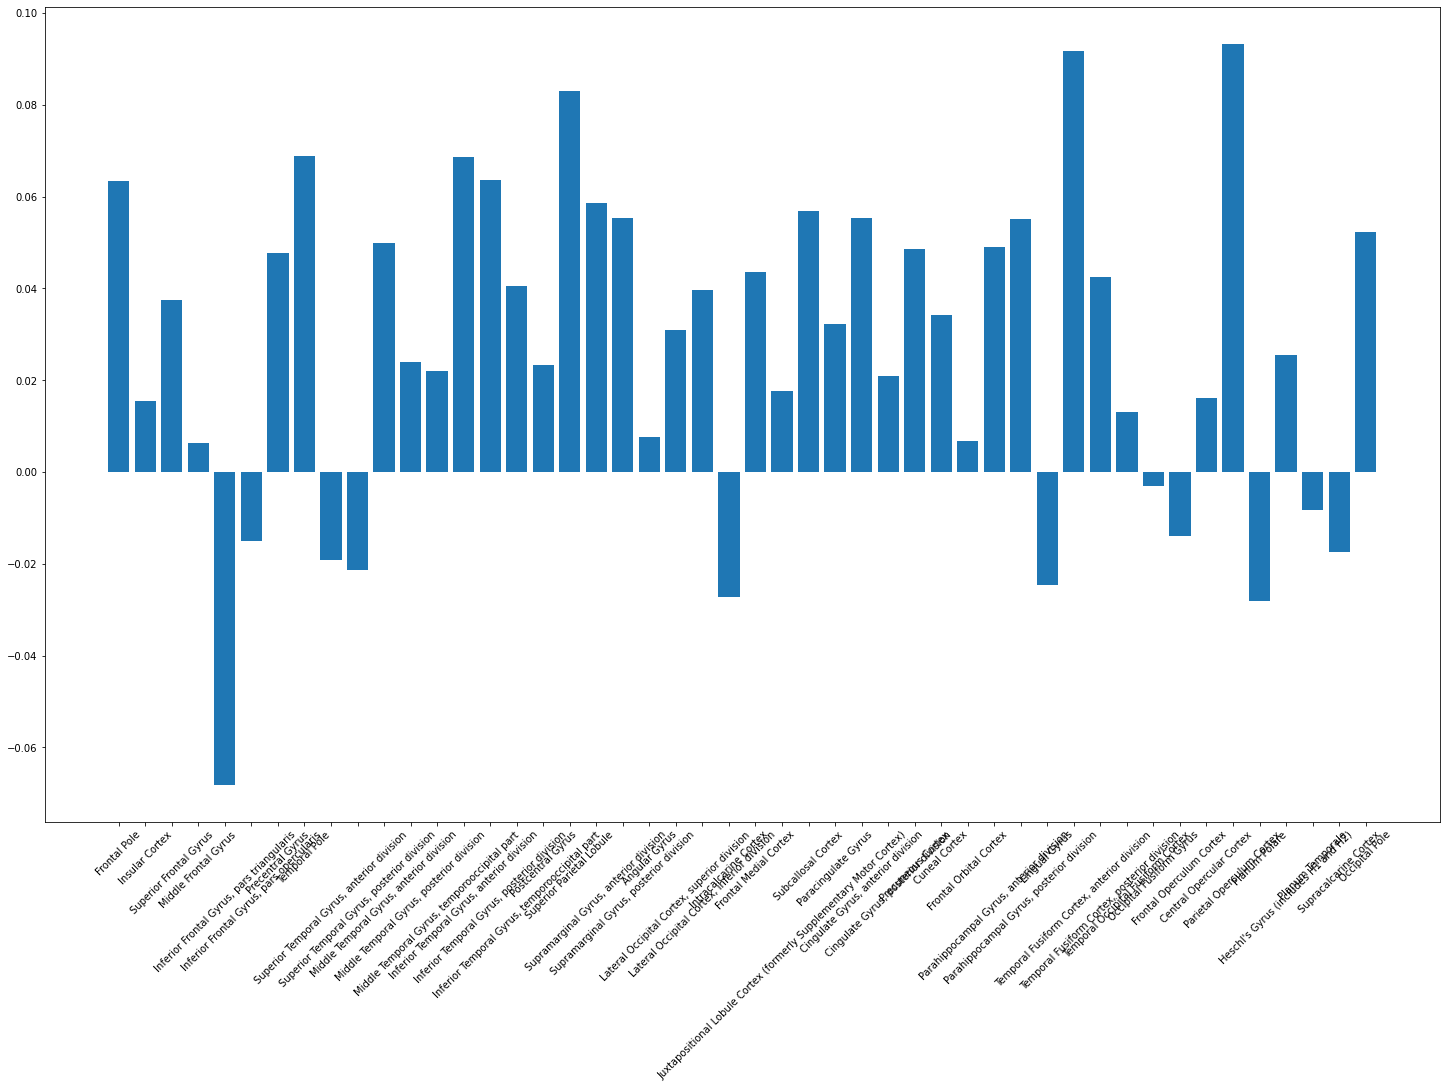

In [ ]:
#Diff for the white matter maps - seems like there is not much of a diff between alz positive vs negative
plt.figure(figsize=(25,15))
plt.bar(atlas_labels[1:], diff_mat)
plt.xticks(rotation = 45)

In [ ]:
wm_mask = datasets.load_mni152_wm_mask()

from nilearn.image import resample_to_img
mask_img = resample_to_img(
    wm_mask, white_matter_maps[0], interpolation='nearest')

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/struct.py:490: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  "from 2mm to 1mm in version 0.10.0", FutureWarning)


In [ ]:
label_a = []

label_n = []


labels_Z = np.zeros((12, ))

for i in range(int(52/8)):
  label_a.append(labels[i])
  label_n.append(labels[len(label_n)-i])

for i in range(int(52/8)):
  labels_Z[i] = label_a[i]

for i in range(int(52/8)):
  labels_Z[i] = label_n[i]


intercept = np.ones(len(labels_Z))

design_matrix = pd.DataFrame(np.vstack((labels, np.ones(53))).T, columns=['labels', 'intercept'])

Text(-10.485, 0.5, 'maps')

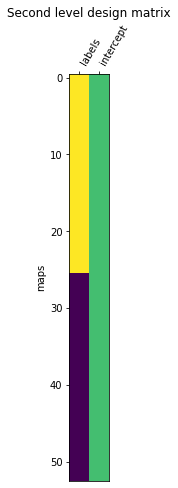

In [ ]:
from nilearn.plotting import plot_design_matrix

# Design matrix that has labels (whether or not a patient has alz)

ax = plot_design_matrix(design_matrix)
ax.set_title('Second level design matrix', fontsize=12)
ax.set_ylabel('maps')


In [ ]:
from nilearn.glm.second_level import SecondLevelModel
second_level_model = SecondLevelModel(smoothing_fwhm=2.0, mask_img=mask_img)
white_matter_z = []
for i in range(int(len(white_matter_maps)/8)):
  white_matter_z.append(white_matter_maps[i])
  white_matter_z.append(white_matter_maps[len(white_matter_maps) - (i+1)])
second_level_model.fit(white_matter_maps,
                       design_matrix=design_matrix)

SecondLevelModel(mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f714f858bd0>,
                 smoothing_fwhm=2.0)

In [ ]:
z_map = second_level_model.compute_contrast(second_level_contrast=[1, 0],
                                            output_type='z_score')


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f714f84ab90>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x7f714f864b10>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x7f716eb8a3d0>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=No

/usr/local/lib/python3.7/dist-packages/nilearn/signal.py:67: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


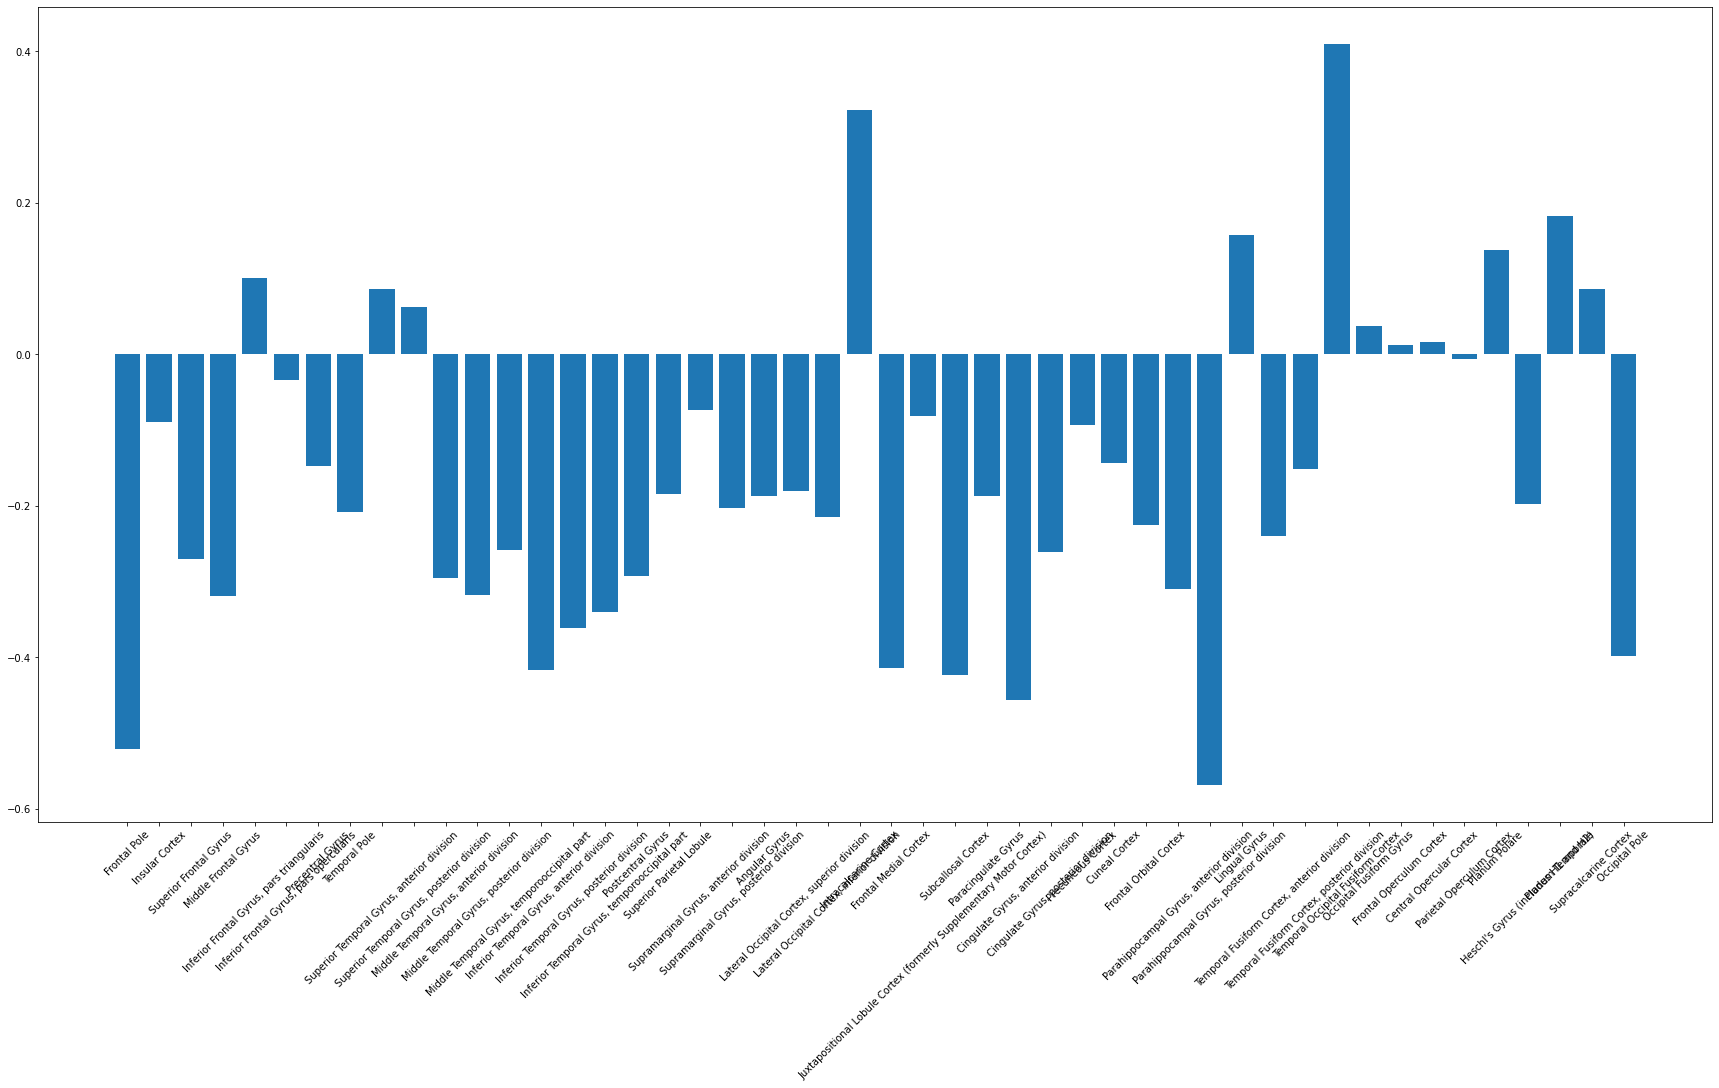

In [ ]:
z_map_mask = masker.fit_transform(z_map)

plt.figure(figsize = (30, 15))
plt.xticks(rotation = 45)
plt.bar(atlas.labels[1:], z_map_mask.flatten())

print(z_map_mask.shape)

The FDR=.05-corrected threshold is: 2.81


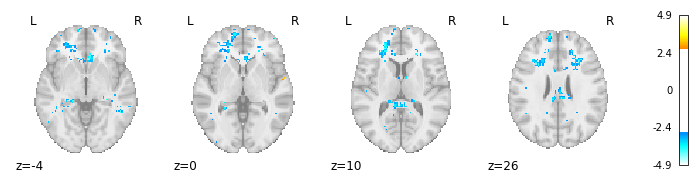

In [ ]:
from nilearn import plotting
from nilearn.glm import threshold_stats_img
_, threshold = threshold_stats_img(
    z_map, alpha=.2, height_control='fdr')
print('The FDR=.05-corrected threshold is: %.3g' % threshold)

display = plotting.plot_stat_map(
    z_map, threshold=threshold, colorbar=True, display_mode='z',
    cut_coords=[-4, 0, 10, 26])
plotting.show()


In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix

# We want a 80 / 20 train test split
train_size = 40/52

test_size = 1 - train_size

X_train, X_test, y_train, y_test = train_test_split(white_matter_masked, labels, test_size=12, random_state=42, stratify = labels)

clf = make_pipeline(StandardScaler(), SVC(gamma='auto', C = 1.8))

fit = clf.fit(X_train, y_train)

scores = cross_val_score(clf, white_matter_masked, labels, cv=5)


# Calculate the mean cross validation score of our model
print("Mean success rate:", np.mean(scores))

y_pred = cross_val_predict(clf, white_matter_masked, labels)

# Matrix that shows Type I and Type II errors - diagonals are correct entries
confusion = confusion_matrix(labels, y_pred)
print("Correct Alz negative classification:", confusion[0][0])
print("Incorrect Alz negative classification:", confusion[0][1])
print("Incorrect Alz positive classification:", confusion[1][0])
print("Correct Alz positive classification:", confusion[1][1])

Mean success rate: 0.8145454545454545
Correct Alz negative classification: 22
Incorrect Alz negative classification: 5
Incorrect Alz positive classification: 5
Correct Alz positive classification: 21
